In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
import cv2

from keras.applications import inception_v3
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as inception_v3_preprocessor

from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

from sklearn.model_selection import train_test_split

from tqdm import tqdm

from os import makedirs
from os.path import expanduser, exists, join

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# NOTE: train and test are now in the 'dog-breed-identification' folder since the Keras Pretrained Models data/directory is added
train_folder = '/content/drive/MyDrive/dog-breed-identification/train'
test_folder = '/content/drive/MyDrive/dog-breed-identification/test'

In [ ]:
train_dogs = pd.read_csv('/content/drive/MyDrive/dog-breed-identification/labels.csv')
train_dogs.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


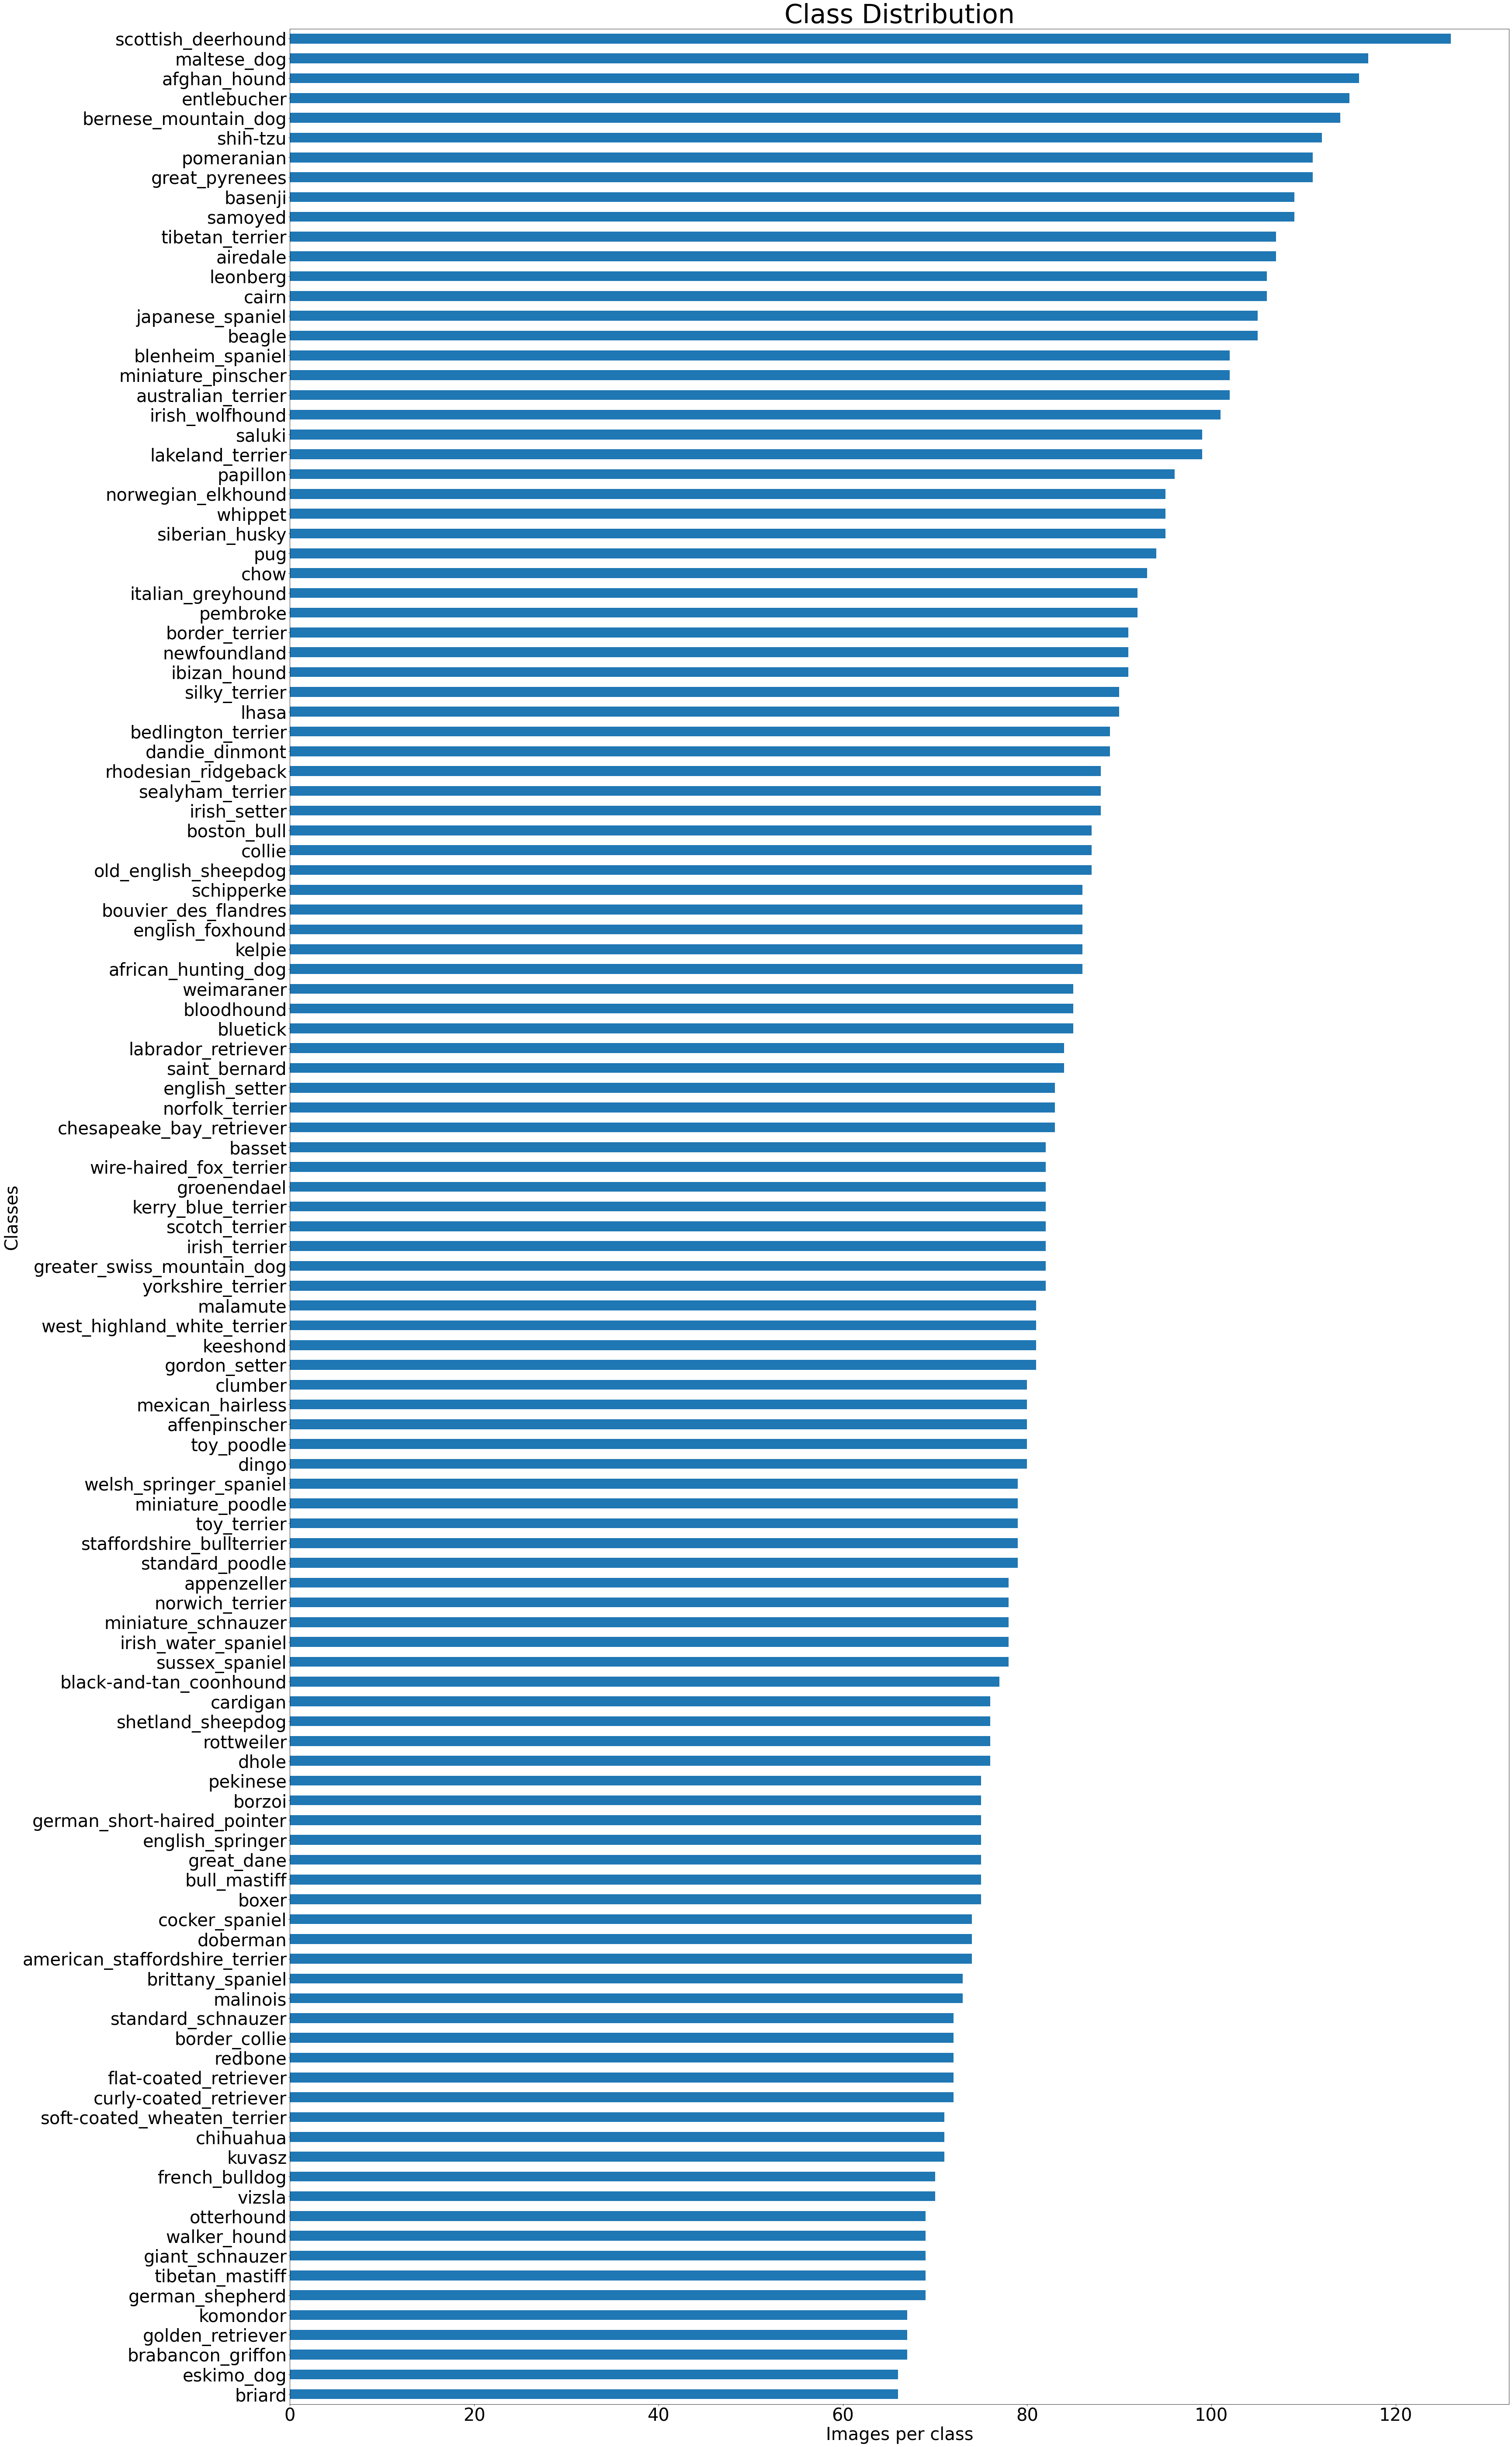

In [ ]:
# Take a look at the class/breed distribution
ax=pd.value_counts(train_dogs['breed'],ascending=True).plot(kind='barh',
                                                       fontsize="40",
                                                       title="Class Distribution",
                                                       figsize=(50,100))
ax.set(xlabel="Images per class", ylabel="Classes")
ax.xaxis.label.set_size(40)
ax.yaxis.label.set_size(40)
ax.title.set_size(60)
plt.show()

In [ ]:
top_breeds = sorted(list(train_dogs['breed'].value_counts().head(20).index))
train_dogs = train_dogs[train_dogs['breed'].isin(top_breeds)]

In [ ]:
print(top_breeds)
train_dogs.shape

['afghan_hound', 'airedale', 'australian_terrier', 'basenji', 'beagle', 'bernese_mountain_dog', 'blenheim_spaniel', 'cairn', 'entlebucher', 'great_pyrenees', 'irish_wolfhound', 'japanese_spaniel', 'leonberg', 'maltese_dog', 'miniature_pinscher', 'pomeranian', 'samoyed', 'scottish_deerhound', 'shih-tzu', 'tibetan_terrier']


(2183, 2)

In [ ]:
print(top_breeds)
train_dogs.shape

['afghan_hound', 'airedale', 'australian_terrier', 'basenji', 'beagle', 'bernese_mountain_dog', 'blenheim_spaniel', 'cairn', 'entlebucher', 'great_pyrenees', 'irish_wolfhound', 'japanese_spaniel', 'leonberg', 'maltese_dog', 'miniature_pinscher', 'pomeranian', 'samoyed', 'scottish_deerhound', 'shih-tzu', 'tibetan_terrier']


(2183, 2)

In [ ]:
target_labels = train_dogs['breed']
one_hot = pd.get_dummies(target_labels, sparse = True)
one_hot_labels = np.asarray(one_hot)

In [ ]:
train_dogs['image_path'] = train_dogs.apply( lambda x: (train_folder +'/' + x["id"] + ".jpg" ), axis=1)
train_dogs.head()

,id,breed,image_path
8,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound,/content/drive/MyDrive/dog-breed-identificatio...
11,00693b8bc2470375cc744a6391d397ec,maltese_dog,/content/drive/MyDrive/dog-breed-identificatio...
28,00bee065dcec471f26394855c5c2f3de,cairn,/content/drive/MyDrive/dog-breed-identificatio...
47,013f8fdf6d638c7bb042f5f17e8a9fdc,tibetan_terrier,/content/drive/MyDrive/dog-breed-identificatio...
56,0162b3e0144fb1d1ab82fbff3ace9938,shih-tzu,/content/drive/MyDrive/dog-breed-identificatio...


In [ ]:
train_data = np.array([img_to_array(load_img(img, target_size=(299, 299))) for img in train_dogs['image_path'].values.tolist()]).astype('float32')

In [ ]:
# Split the data into train and validation. The stratify parm will insure  train and validation  
# will have the same proportions of class labels as the input dataset.
x_train, x_validation, y_train, y_validation = train_test_split(train_data, target_labels, test_size=0.2, stratify=np.array(target_labels), random_state=100)

In [ ]:
# calculate steps_per_epoch and validatoin_steps for the model.fit_generator
print ('x_train shape = ', x_train.shape)
print ('x_validation shape = ', x_validation.shape)

x_train shape =  (1746, 299, 299, 3)
x_validation shape =  (437, 299, 299, 3)


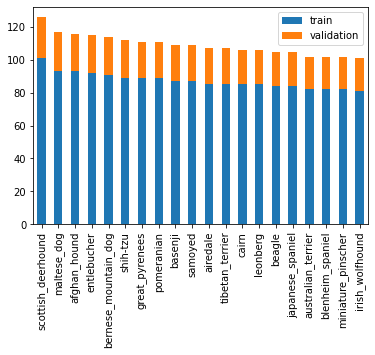

In [ ]:
# Calculate the value counts for train and validation data and plot to show a good stratify
# the plot should show an equal percentage split for each class
data = y_train.value_counts().sort_index().to_frame()   # this creates the data frame with train numbers
data.columns = ['train']   # give the column a name
data['validation'] = y_validation.value_counts().sort_index().to_frame()   # add the validation numbers
new_plot = data[['train','validation']].sort_values(['train']+['validation'], ascending=False)   # sort the data
new_plot.plot(kind='bar', stacked=True)
plt.show()

In [ ]:
# Need to convert the train and validation labels into one hot encoded format
y_train = pd.get_dummies(y_train.reset_index(drop=True)).values
y_validation = pd.get_dummies(y_validation.reset_index(drop=True)).values

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=30, 
                                   # zoom_range = 0.3, 
                                   width_shift_range=0.2,
                                   height_shift_range=0.2, 
                                   horizontal_flip = 'true')
train_generator = train_datagen.flow(x_train, y_train, shuffle=False, batch_size=10, seed=10)

val_datagen = ImageDataGenerator(rescale = 1./255)
val_generator = train_datagen.flow(x_validation, y_validation, shuffle=False, batch_size=10, seed=10)

In [ ]:
# Get the InceptionV3 model so we can do transfer learning
base_model = InceptionV3(weights = 'imagenet', include_top = False, input_shape=(299, 299, 3))

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

In [ ]:
# Add a fully-connected layer and a logistic layer with 20 classes 
#(there will be 120 classes for the final submission)
x = Dense(512, activation='relu')(x)
predictions = Dense(20, activation='softmax')(x)

In [ ]:
#The model we will train
model = Model(inputs = base_model.input, outputs = predictions)

In [ ]:
# first: train only the top layers i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Compile with Adam
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit_generator(train_generator,
                      steps_per_epoch = 175,
                      validation_data = val_generator,
                      validation_steps = 44,
                      epochs = 10,
                      verbose = 2)

Epoch 1/10
175/175 - 89s - loss: 1.0614 - accuracy: 0.7967 - val_loss: 0.3302 - val_accuracy: 0.9359
Epoch 2/10
175/175 - 49s - loss: 0.2388 - accuracy: 0.9364 - val_loss: 0.2150 - val_accuracy: 0.9291
Epoch 3/10
175/175 - 48s - loss: 0.1847 - accuracy: 0.9479 - val_loss: 0.2119 - val_accuracy: 0.9314
Epoch 4/10
175/175 - 49s - loss: 0.1566 - accuracy: 0.9502 - val_loss: 0.1900 - val_accuracy: 0.9428
Epoch 5/10
175/175 - 49s - loss: 0.1247 - accuracy: 0.9616 - val_loss: 0.1993 - val_accuracy: 0.9451
Epoch 6/10
175/175 - 50s - loss: 0.1100 - accuracy: 0.9685 - val_loss: 0.2114 - val_accuracy: 0.9359
Epoch 7/10
175/175 - 49s - loss: 0.1172 - accuracy: 0.9645 - val_loss: 0.1817 - val_accuracy: 0.9451
Epoch 8/10
175/175 - 49s - loss: 0.1157 - accuracy: 0.9599 - val_loss: 0.2279 - val_accuracy: 0.9153
Epoch 9/10
175/175 - 48s - loss: 0.0992 - accuracy: 0.9691 - val_loss: 0.2120 - val_accuracy: 0.9359
Epoch 10/10
175/175 - 48s - loss: 0.0890 - accuracy: 0.9668 - val_loss: 0.2331 - val_accura

In [ ]:
#Save the model
model.save('dogbreed-model1.h5')